<a href="https://colab.research.google.com/github/NavaLeib/Cells_Barcoding/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [497]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [498]:
import sys

sys.path.insert(0,'/content/drive/MyDrive/ColabNotebooks/Barcoding')


In [499]:
!ls '/content/drive/MyDrive/ColabNotebooks/Barcoding'

functions.py  _init_.py  main.ipynb


In [500]:
from functions import *

In [501]:
 pip install networkx

In [503]:
# -*- coding: utf-8 -*-


import numpy as np
from difflib import SequenceMatcher
import networkx as nx



class SmallSystem:

    def __init__(self, barcodes, cells):
        self.barcodes = barcodes
        self.cells = cells
        self.X=np.empty(cells, dtype="<U100")


    def generate_barcoded_cells(self,p):
        XX = np.empty(self.cells, dtype="<U100")  # U6: 6 differnt letters can be inserted
        for bar in range(65, 65 + int(self.barcodes)):  # just to get 1st barcodes as 'A' (=65 in Ascii)
            for i in range(self.cells):
                if np.random.rand() <= p:#*(len(X[i])/50)**(1/3)+0.01:
                    XX[i] = XX[i] + chr(bar)
        self.X=XX
        return self.X

    def number_of_lineages(X, cells, number_of_infected):
        flag = 0
        lineage = 0
        Prob_SubSet = 0
        for i in range(cells):
            for j in range(cells):
                if (i != j) & (len(X[i]) > 0) & (flag == 0):
                    if (X[i] in X[j]):
                        Prob_SubSet = Prob_SubSet + (X[i] in X[j])
                        flag = 1
                if (i != j) & (len(X[i]) > 0) & (X[i] == X[j]):
                    lineage = lineage + 1 / 2
        return number_of_infected - lineage

    def prob_complete_subset(X, cells):
        flag = 0
        lineage = 0
        Prob_SubSet = 0
        for i in range(cells):
            for j in range(cells):
                if (i != j) & (len(X[i]) > 0) & (flag == 0):
                    if (X[i] in X[j]):
                        Prob_SubSet = Prob_SubSet + (X[i] in X[j])
                        flag = 1
                if (i != j) & (len(X[i]) > 0) & (X[i] == X[j]):
                    lineage = lineage + 1 / 2
        return Prob_SubSet

    def overlap(X1,X2,cells):
        Prob_overlap = 0
        for i in range(cells):
            for j in range(cells):
                if  (len(X1[i]) > 0) & (len(X2[j]) > 0) :
      #          if (X1[i] in X2[j]) or (X2[j] in X1[i]) :
                    if (X1[i] == X2[j])  :
                        Prob_overlap = Prob_overlap + 1
        return Prob_overlap

    def number_of_infected(X, cells):
        number_of_infected = 0
        for i in range(cells):
            number_of_infected += (len(X[i]) > 0)
        return number_of_infected

    def drop_out(X, dropout_prob):
        X_afterdrop = X.copy()
        for i in range(len(X)):
            One_Cell = X[i]
            Init_Barcode_Len = len(One_Cell)
            for j in range(Init_Barcode_Len - 1, -1, -1):
                if np.random.rand() <= dropout_prob:
                #                print(i, j, One_Cell)
                    One_Cell = One_Cell.replace(One_Cell[j], '')
                #                print(i, j, One_Cell)
                    X_afterdrop[i] = One_Cell
        return X_afterdrop
        
     

    def SimilarityMatrix(X):
        A=np.zeros([len(X),len(X)])
        for i in range(len(X)):
            for j in range(len(X)):
                A[i,j]=SequenceMatcher(None,X[i],X[j]).ratio()
        return A
    
        
def NetworkPlot(A,labels,edge_width=0.1,node_size=10):
    dt = [('len', float)]
    A = A.view(dt)
    G = nx.from_numpy_matrix(A,create_using=nx.MultiGraph)
    G = nx.relabel_nodes(G, dict(zip(range(len(G.nodes())),labels)))    
    pos=nx.spring_layout(G)
    d = dict(G.degree)
    nx.draw_networkx(G,pos=pos,width=edge_width,node_size=[v * node_size for v in d.values()],node_color=[(v-2)**0.5  for v in d.values()])
    return True

def sim(list1,list2):
    res = len(set(list1) & set(list2)) / float(len(set(list1) | set(list2))) 
    return float(res)

class LargeSystem:

    def __init__(self, barcodes, cells):
        self.barcodes = barcodes
        self.cells = cells
        self.X = np.zeros([cells, barcodes], dtype=int)  


    def generate_barcoded_cells(self, p, Poisson):
        XX = np.zeros([cells, barcodes], dtype=int)  
        if Poisson==True:
            for bar in range(barcodes): 
                for i in range(cells):
                    if np.random.rand() <=p:
                        XX[i][bar] = 1
        else:
            for bar in range(barcodes): 
                for i in range(cells):  
                    if np.random.rand() <=(XX[i,:].sum()/barcodes)**(1/1)+1/(2*barcodes):
                        XX[i][bar] = 1
        self.X=XX
        return self.X

    def dropouts(X, p):
        barcodes=X.shape[1]
        cells=X.shape[0]
        for bar in range(barcodes): 
            for i in range(cells):
                if np.random.rand() <=p:   #(X[i,:].sum()/barcodes)**(1/1)+1/(2*barcodes):
                    X[i][bar] = 0
        return X

    def SimilarityMatrix(X):
        A=np.zeros([len(X),len(X)])
        for i in range(len(X)):
            for j in range(len(X)):
                A[i,j]=sim(([l for l in np.flatnonzero(X[j,:])]),([l for l in np.flatnonzero(X[i,:])]))
        return A

    def DistanceMatrix_dropout(X,dropout_prob):
        A=np.zeros([len(X),len(X)])
        for i in range(len(X)):
            for j in range(len(X)):
                Union_len=len(set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])]))
                Pij_sim_len = len((set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])])) & set([l for l in np.flatnonzero(X[i,:])]))
                Pji_sim_len = len((set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])])) & set([l for l in np.flatnonzero(X[j,:])]))
                A[i,j]=(1-dropout_prob)**Pij_sim_len*dropout_prob**(Union_len-Pij_sim_len)*(1-dropout_prob)**Pji_sim_len*dropout_prob**(Union_len-Pji_sim_len)
                if j==i:
                    A[i,j]=1
        return A



In [504]:
cells = 50
barcodes = 50
system=LargeSystem(barcodes=barcodes,cells=cells)


39


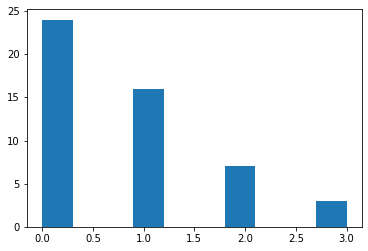

In [505]:
system=system.generate_barcoded_cells(p=0.01,Poisson=True)
plt.hist(system.sum(axis=1))
print(system[system.sum(axis=1)>0].sum())

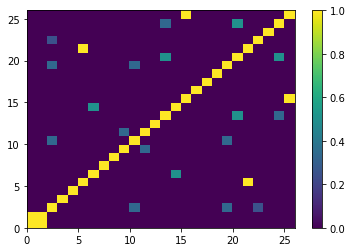

In [506]:
A=LargeSystem.SimilarityMatrix(system[system.sum(axis=1)>0])
plt.pcolormesh(A)
plt.colorbar()
#plt.xticks(np.arange(0.5,len([x for x in system if x]), 1),[x for x in system if x])
#plt.yticks(np.arange(0.5,len([x for x in system if x]), 1),[x for x in system if x])


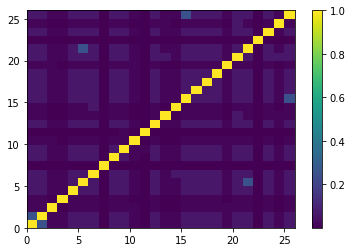

In [507]:
dropout_prob=0.5
AA=LargeSystem.DistanceMatrix_dropout(system[system.sum(axis=1)>0],dropout_prob=dropout_prob)
plt.pcolormesh(AA)
plt.colorbar()

(26, 50)


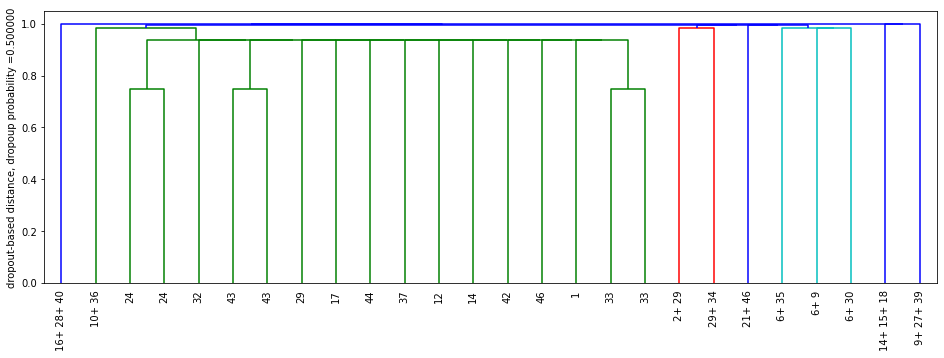

In [508]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt

X_infect=system[system.sum(axis=1)>0]

print(X_infect.shape)

labels = ["" for x in range(X_infect.shape[0])]
for k in range(X_infect.shape[0]):
    labels[k]=''.join("+ ").join([str(l) for l in np.flatnonzero(X_infect[k,:])])


plt.figure(figsize=(16,5))
dists = squareform(1-AA)
linkage_matrix = linkage(dists, "complete")
R=dendrogram(linkage_matrix,color_threshold=0.99,labels=labels,leaf_rotation=90)
plt.ylabel("dropout-based distance, dropoup probability =%f" %dropout_prob)
plt.show()

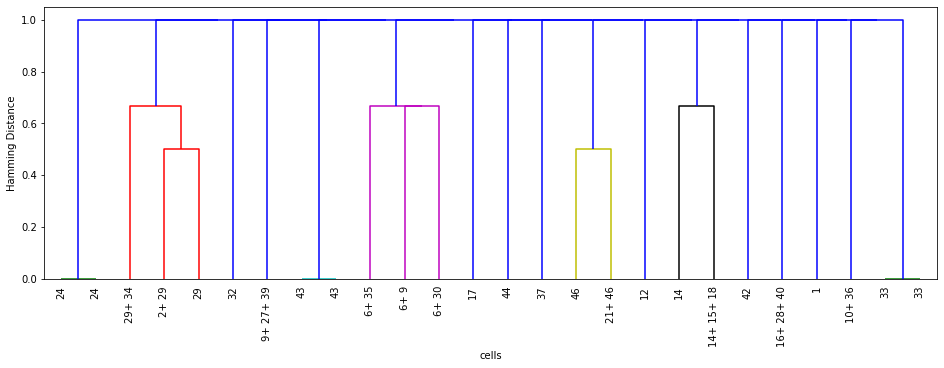

In [509]:
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

import matplotlib.pyplot as plt

X_infect=system[system.sum(axis=1)>0]

labels = ["" for x in range(X_infect.shape[0])]
for k in range(X_infect.shape[0]):
    labels[k]=''.join("+ ").join([str(l) for l in np.flatnonzero(X_infect[k,:])])


plt.figure(figsize=(16,5))
dists = squareform(1-A)
linkage_matrix = linkage(dists, "complete")
R=dendrogram(linkage_matrix,color_threshold=0.9,labels=labels,leaf_rotation=90)
plt.ylabel("Hamming Distance")
plt.xlabel("cells")
plt.show()

In [510]:
X=system[system.sum(axis=1)>0]
i=0
j=11
dropout_prob=0.2
Union_len=len(set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])]))
Pij_sim_len = len((set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])])) & set([l for l in np.flatnonzero(X[i,:])]))
Pji_sim_len = len((set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])])) & set([l for l in np.flatnonzero(X[j,:])]))
(1-dropout_prob)**Pij_sim_len*dropout_prob**(Union_len-Pij_sim_len)+(1-dropout_prob)**Pji_sim_len*dropout_prob**(Union_len-Pji_sim_len)
print(set([l for l in np.flatnonzero(X[i,:])]) , set([l for l in np.flatnonzero(X[j,:])]))
print('Union',(set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])])), Union_len )
print('overlap with Union',(set([l for l in np.flatnonzero(X[i,:])]) | set([l for l in np.flatnonzero(X[j,:])])) & set([l for l in np.flatnonzero(X[i,:])]),Pij_sim_len)
print(1-(1-dropout_prob)**Pij_sim_len*dropout_prob**(Union_len-Pij_sim_len)*(1-dropout_prob)**Pji_sim_len*dropout_prob**(Union_len-Pji_sim_len)
)

{33} {18, 14, 15}
Union {33, 18, 14, 15} 4
overlap with Union {33} 1
0.99934464


True

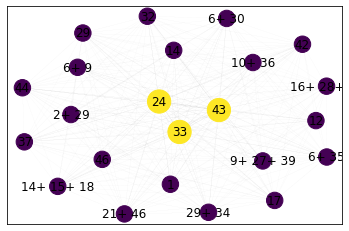

In [511]:
NetworkPlot(A=AA,labels=labels,edge_width=0.01,node_size=10)

True

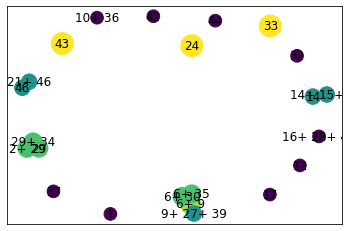

In [512]:
NetworkPlot(A=A,labels=labels,edge_width=0.1,node_size=80)